# 1. Ablation Study 실습(1)
- dataset: CIFAR-10 dataset
- method: 일반 네트워크 vs. ResNet
- objective: ResNet, Residual connection의 유효성 확인


In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
!pip install torchinfo
from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


## 1.1 dataset

CIRAR-10

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [3]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10


In [4]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


Normalization

In [5]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

In [6]:
num_classes = len(trainset.classes)
print(num_classes)

class_names = trainset.classes
print(class_names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [8]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

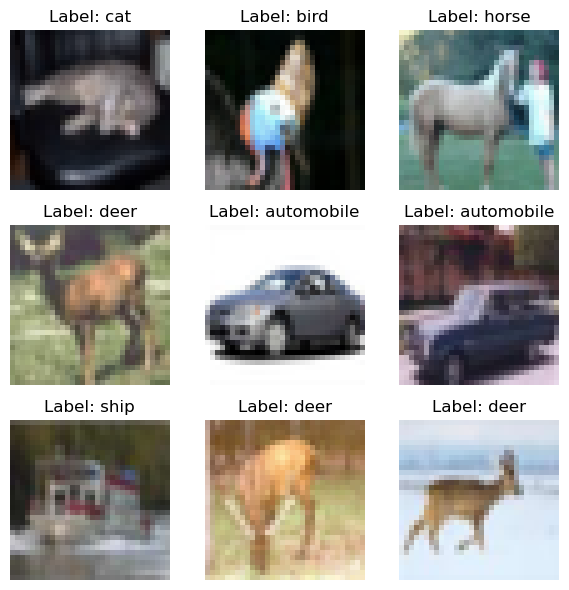

In [9]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

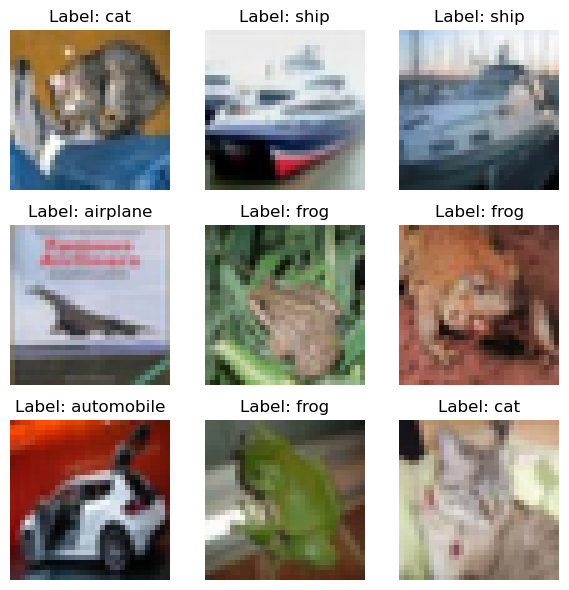

In [10]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

## 1.2 블록 구성하기

### VGG 기본 블록 만들기  

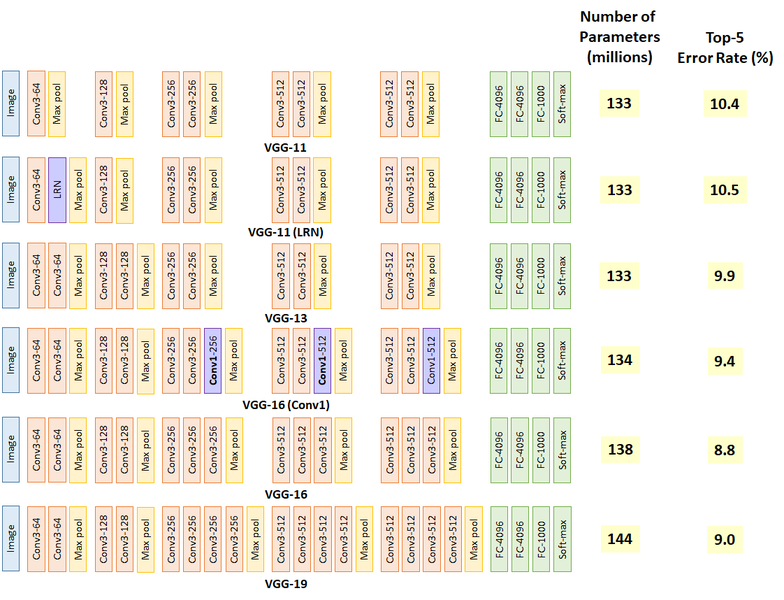  
- 기본구조: CNN 레이어 여러 개 + Max pooling 레이어 한 개
  - CNN의 커널 크기는 3*3
  - 블록 내 CNN 채널은 하나로 유지, 다른 블록 간 CNN 채널 수는 다를 수 있음. 레이어 수도 다를 수 있음
    -> (ex.VGG-16에서 블록1: Conv3-64 2개, 블록2: Conv3-128 2개, 블록3: Conv3-256 3개)

In [11]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channel,
                kernel_size=3,
                stride=1,
                padding=1,
            )
        )
        layers.append(nn.ReLU(inplace=True))
        in_channels = channel

    # Max Pooling 레이어
    layers.append(
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [12]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG 블록 생성
        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32)) # 위에서 입력 Image shape: torch.Size([3, 32, 32])
        
    def forward(self, x):
        return self.vgg_block(x)

In [13]:
# 블록 1개짜리 model 생성
model = VGGNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32) # 위에서 입력 Image shape: torch.Size([3, 32, 32])
output = model(dummy_input)
print(output.shape)

VGGNet(
  (vgg_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 64, 16, 16])


## 1.3 VGG Complete Model


### VGG-16

In [14]:
# VGG 모델 자체를 생성하는 클래스입니다.
class VGG(nn.Module):
    def __init__(self, num_cnn_list=[2, 2, 3, 3, 3], channel_list=[64, 128, 256, 512, 512], num_classes=10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 합니다."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list): ## num_cnn_list, channel_list를 입력하면 다른 VGG-* 생성됨
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels  # 다음 블록의 입력 채널을 설정

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [15]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = VGG()
print(vgg_16)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

### VGG-19

In [16]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
summary(vgg_19)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 590,080
│    │    └─ReLU: 3-16                  

### VGG-13

In [17]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )

In [22]:
vgg_13 = build_vgg13()
summary(vgg_13)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─MaxPool2d: 3-15              --
│    └─Sequential: 2-4                   --
│

## 1.4 VGG-16 vs VGG-19

In [19]:
BATCH_SIZE = 256
EPOCH = 15

In [20]:
# CIFAR-10 데이터셋에 대해 Normalize와 Tensor 변환을 적용하는 코드
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-16 표준 정규화
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
# VGG-16

import time

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_16 = torchvision.models.vgg16(pretrained=True)
vgg_16.to(device)

for param in vgg_16.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_16_train_losses = []
vgg_16_val_accuracy = []

for epoch in range(EPOCH):
    vgg_16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")
            
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    vgg_16_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_16.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_16_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

[1,   100] loss: 3.969
Epoch 1: Train Accuracy: 40.49%
Epoch 1: Validation Accuracy: 66.95%
[2,   100] loss: 1.887
Epoch 2: Train Accuracy: 72.10%
Epoch 2: Validation Accuracy: 76.47%
[3,   100] loss: 1.651
Epoch 3: Train Accuracy: 78.96%
Epoch 3: Validation Accuracy: 79.19%
[4,   100] loss: 1.523
Epoch 4: Train Accuracy: 82.82%
Epoch 4: Validation Accuracy: 81.21%
[5,   100] loss: 1.450
Epoch 5: Train Accuracy: 84.98%
Epoch 5: Validation Accuracy: 81.47%
[6,   100] loss: 1.394
Epoch 6: Train Accuracy: 87.04%
Epoch 6: Validation Accuracy: 83.50%
[7,   100] loss: 1.345
Epoch 7: Train Accuracy: 88.54%
Epoch 7: Validation Accuracy: 83.46%
[8,   100] loss: 1.280
Epoch 8: Train Accuracy: 90.60%
Epoch 8: Validation Accuracy: 82.97%
[9,   100] loss: 1.249
Epoch 9: Train Accuracy: 91.82%
Epoch 9: Validation Accuracy: 84.11%
[10,   100] loss: 1.218
Epoch 10: Train Accuracy: 92.74%
Epoch 10: Validation Accuracy: 85.04%
[11,   100] loss: 1.185
Epoch 11: Train Accuracy: 93.87%
Epoch 11: Validation

In [24]:
# VGG-19

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_19 = torchvision.models.vgg19(pretrained=True)
vgg_19.to(device)

for param in vgg_19.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_19_train_losses = []
vgg_19_val_accuracy = []

for epoch in range(EPOCH):
    vgg_19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")

    train_loss = running_loss / len(trainloader)
    vgg_19_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_19.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_19(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_19_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 218MB/s] 


[1,   100] loss: 3.761
Epoch 1: Train Accuracy: 42.03%
Epoch 1: Validation Accuracy: 66.54%
[2,   100] loss: 1.821
Epoch 2: Train Accuracy: 73.80%
Epoch 2: Validation Accuracy: 79.05%
[3,   100] loss: 1.584
Epoch 3: Train Accuracy: 80.90%
Epoch 3: Validation Accuracy: 79.81%
[4,   100] loss: 1.498
Epoch 4: Train Accuracy: 83.86%
Epoch 4: Validation Accuracy: 82.38%
[5,   100] loss: 1.407
Epoch 5: Train Accuracy: 86.46%
Epoch 5: Validation Accuracy: 84.39%
[6,   100] loss: 1.354
Epoch 6: Train Accuracy: 88.23%
Epoch 6: Validation Accuracy: 84.70%
[7,   100] loss: 1.304
Epoch 7: Train Accuracy: 89.55%
Epoch 7: Validation Accuracy: 85.44%
[8,   100] loss: 1.269
Epoch 8: Train Accuracy: 90.85%
Epoch 8: Validation Accuracy: 85.36%
[9,   100] loss: 1.231
Epoch 9: Train Accuracy: 92.05%
Epoch 9: Validation Accuracy: 84.61%
[10,   100] loss: 1.196
Epoch 10: Train Accuracy: 93.47%
Epoch 10: Validation Accuracy: 86.04%
[11,   100] loss: 1.169
Epoch 11: Train Accuracy: 94.39%
Epoch 11: Validation

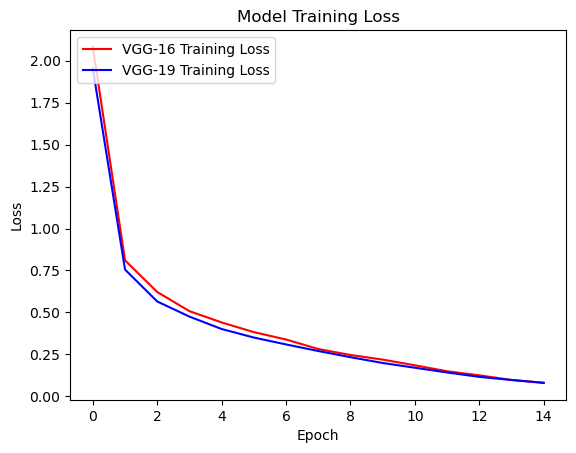

In [25]:
# 그래프 비교

import matplotlib.pyplot as plt

plt.plot(vgg_16_train_losses, 'r', label="VGG-16 Training Loss")
plt.plot(vgg_19_train_losses, 'b', label="VGG-19 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

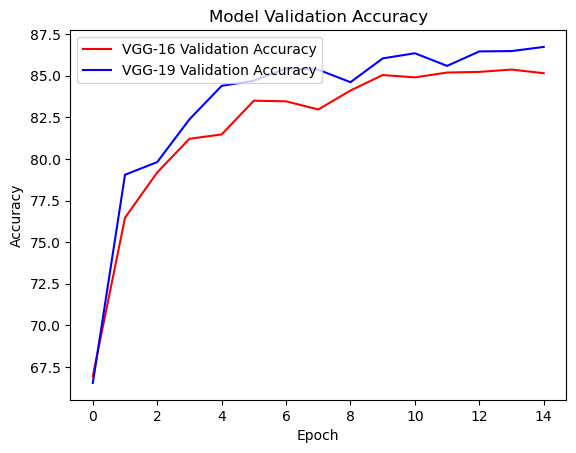

In [26]:
# 검증 정확도(Validation accuracy) 비교

plt.plot(vgg_16_val_accuracy, 'r', label="VGG-16 Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label="VGG-19 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 2. 프로젝트: ResNet Ablation Study

라이브러리 버전 확인하기

In [27]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
!pip install torchinfo
from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(torch.__version__)
print(np.__version__)

2.7.1+cu118
2.2.6


## 2.1 ResNet 기본 블록 구성하기

   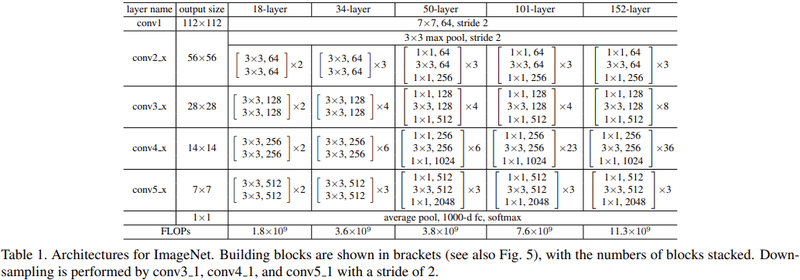  
   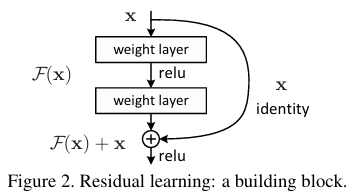  
   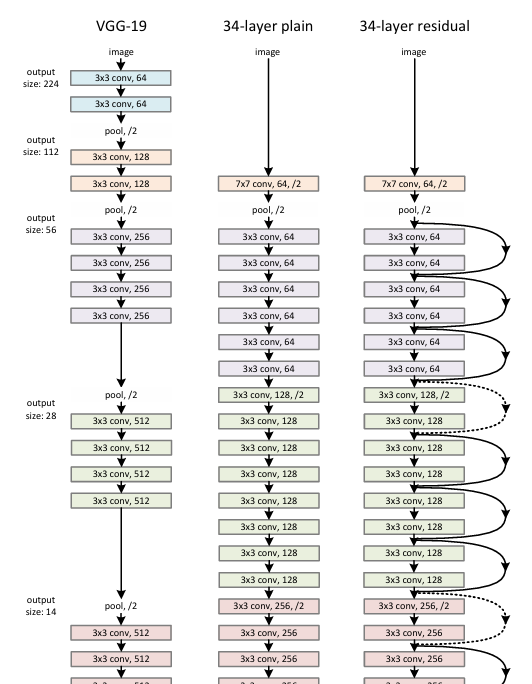  
   

   - ResNet-34와 ResNet-50 비교하기
     - conv1은 7*7, 64, stride 2로 동일함
     - 마지막 layer도 1*1 size의 average pool, 1000-d fe, softmax로 동일함
     - conv2_x, conv3_x, conv4_x, conv5_x 블록을 3, 4, 6, 3개씩 반복해서 쌓은 형태임  
       내부 구조:
       - ResNet-34은 커널 크기 3*3인 Convolution layer로만 구성되어있음
       - ResNet-50은 커널 크기 3*3인 Convolution layer 1개에 1*1 Convolution layer 1개가 앞뒤로 붙어있음
       - 채널은 블록마다 64, 128, 256, 512로 다름

In [3]:
# function for building ResNet Block (기본구조 세팅)
'''
Conv → BN → ReLU
Conv → BN
+ identity
→ ReLU
'''

def build_resnet_block(input_layer, num_cnn=2, channel=64, block_num=1):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channel, kernel_size=3, stride=1, padding=1)) # conv2_x stride=1, conv3_x부터 stride=2
        layers.append(nn.BatchNorm2d(channel)) # 채널 수 맞춰서 BatchNorm 생성

        if cnn_num != num_cnn - 1:
            layers.append(nn.ReLU(inplace=True)) # 마지막 conv 제외하고 나머지 레이어에만 relu 추가
            
        in_channels = channel

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [4]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # ResNet 블록 생성
        self.resnet_block = build_resnet_block(torch.zeros(1, 3, 32, 32), num_cnn=2, channel=64) # 위에서 입력 Image shape: torch.Size([3, 32, 32])
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x # 추가. 잔차 connection
        out = self.resnet_block(x)
    
        # 공간 크기 맞추기
        if identity.shape[2:] != out.shape[2:]:
            identity = F.interpolate(identity, size=out.shape[2:], mode="nearest") # identity를 out과 동일한 공간 크기로 맞춤
    
        # 채널 수 맞추기
        if identity.size(1) != out.size(1):
            diff = out.size(1) - identity.size(1) 
            identity = F.pad(identity, (0, 0, 0, 0, 0, diff)) # 차이(diff)만큼 identity에 padding
    
        out = out + identity

        return self.relu(out)

In [5]:
# 테스트 - 블록 1개짜리 model 생성
model = ResNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32)
output = model(dummy_input)
print(output.shape)

ResNet(
  (resnet_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
)
torch.Size([1, 64, 32, 32])


## 2.2 ResNet-34, ResNet-50 Complete Model

In [7]:
# Sequential API? Functional API!

**ResNet-34**  
```
Input: 3×32×32
↓
conv1: 7×7, 64, stride=2, padding=3 → 16×16
↓
BN → ReLU
↓
maxpool: 3×3, stride=2, padding=1 → 8×8
↓
stage1 (conv2_x): [3×3, 64 → 3×3,64] × 3
stage2 (conv3_x): [3×3, 128 → 3×3, 128] × 4, first stride=2
stage3 (conv4_x): [3×3, 256 → 3×3, 256] × 6, first stride=2
stage4 (conv5_x): [3×3, 512 → 3×3, 512] × 3, first stride=2
↓
AdaptiveAvgPool(1×1)
↓
FC(10)
```

In [9]:
!pip install torchinfo

In [28]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False # bias True/False 설정에 따라 parameter 수가 달라짐. 왜??
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


In [29]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super().__init__()
        self.in_channels = 64

        # stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        # stages
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        # head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        # 첫 블록 stride 적용
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks-1):
            layers.append(block(self.in_channels, out_channels, 1))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)

        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [30]:
def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

In [31]:
resnet34 = ResNet34(num_classes=37)
summary(resnet34, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-5                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│

ResNet-50  
```
Input: 3×32×32
↓
conv1: 7×7, 64, stride=2, padding=3 → 16×16
↓
BN → ReLU
↓
maxpool: 3×3, stride=2, padding=1 → 8×8
↓
stage1 (conv2_x): [1×1,64 → 3×3,64 → 1×1,256] × 3
stage2 (conv3_x): [1×1,64 → 3×3,128 → 1×1,512] × 4, first stride=2
stage3 (conv4_x): [1×1,64 → 3×3,256 → 1×1,1024] × 6, first stride=2
stage4 (conv5_x): [1×1,64 → 3×3,512 → 1×1,2048] × 3, first stride=2
↓
AdaptiveAvgPool(1×1)
↓
FC(10)
```

In [32]:
class Bottleneck(nn.Module):
    expansion = 4  # ResNet-50 핵심

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # 1x1 conv (channel reduction)
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1, stride=stride, bias=False # bias True/False 설정에 따라 parameter 수가 달라짐. 왜??
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 conv
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1 conv
        self.conv3 = nn.Conv2d(
            out_channels, out_channels * self.expansion,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        # shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels * self.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


In [33]:
#ResNet은 ResNet34와 동일함

In [34]:
def ResNet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

In [35]:
resnet50 = ResNet50(num_classes=37)
summary(resnet50, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-5                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│ 

## 2.3 일반 네트워크(plain network) 만들기 추가
- ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요.
- 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [53]:
# use_skip 추가하여 use_skip=True일때는 ResNet, False일때는 plain이 되게끔 구현함

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, use_skip=True):
        super().__init__()
        self.use_skip = use_skip # use_skip 추가함

        # 1
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=True # bias True/False 설정에 따라 parameter 수가 달라짐. 왜??
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 2
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=True
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if self.use_skip == True: # use_skip = True 일때만 활성
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_channels, out_channels,
                        kernel_size=1, stride=stride, bias=True
                    ),
                    nn.BatchNorm2d(out_channels)
                )
        else:
            self.shortcut = None  # skip 안 쓰면 None

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
    
        out = self.conv2(out)
        out = self.bn2(out)
    
        # shortcut이 있을 때만 residual 연결
        if self.shortcut is not None:
            out += self.shortcut(x)
    
        out = self.relu(out)
        
        return out

In [54]:
# use_skip 추가함

class Bottleneck(nn.Module):
    expansion = 4  # ResNet-50 핵심

    def __init__(self, in_channels, out_channels, stride=1, use_skip=True):
        super().__init__()
        self.use_skip = use_skip

        # 1x1 conv (channel reduction)
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1, stride=stride, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 conv
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1 conv
        self.conv3 = nn.Conv2d(
            out_channels, out_channels * self.expansion,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        # shortcut
        self.shortcut = nn.Sequential()
        if self.use_skip == True :
            if stride != 1 or in_channels != out_channels * self.expansion:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_channels, out_channels * self.expansion,
                        kernel_size=1, stride=stride, bias=False
                    ),
                    nn.BatchNorm2d(out_channels * self.expansion)
                )
        else:
            self.shortcut = None  # skip connection 제거          

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        # shortcut이 있을 때만 residual 연결
        if self.shortcut is not None:
            out += self.shortcut(x)

        out = self.relu(out)
        
        return out


In [55]:
# use_skip 추가함

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, use_skip=True): #use_skip=True 추가
        super().__init__()
        self.in_channels = 64
        self.use_skip = use_skip # use_skip추가

        # stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        # stages
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        # head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)


    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        # 첫 블록 stride 적용
        layers.append(block(self.in_channels, out_channels, stride, use_skip=self.use_skip)) # use_skip추가
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks-1):
            layers.append(block(self.in_channels, out_channels, use_skip=self.use_skip)) # use_skip추가
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.stem(x)

        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out


In [61]:
def build_ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, use_skip=True)

def build_plainnet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, use_skip=False)

def build_ResNet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, use_skip=True)
    
def build_plainnet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, use_skip=False)

In [62]:
resnet34 = build_ResNet34(num_classes=37)
summary(resnet34, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-5                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│

In [63]:
plain_resnet34 = build_plainnet34(num_classes=37)
summary(plain_resnet34, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-5                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│

In [64]:
resnet50 = build_ResNet50(num_classes=37)
summary(resnet50, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-5                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│ 

In [65]:
plain_resnet50 = build_plainnet50(num_classes=37)
summary(plain_resnet50, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-5                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│ 

## 2.4 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### 데이터 로드

In [36]:
BATCH_SIZE = 256
EPOCH = 10

In [37]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기 맞춤
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',    # train set
    download=True,
    transform=transform,
    target_types='category'  # 클래스 라벨
)

testset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='test',        # test set
    download=True,
    transform=transform,
    target_types='category'
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

#### 데이터 탐색

In [38]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 224, 224])
Label: 0
Number of classes: 37


In [39]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 3680 (Shape: torch.Size([]))
Test dataset size: 3669 (Shape: torch.Size([]))


In [40]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

In [41]:
num_classes = len(trainset.classes)
print(num_classes)

37


In [42]:
class_names = trainset.classes
print(class_names)

['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [43]:
def imshow(img):
    img = img / 2 + 0.5
    img = torch.clamp(img, 0, 1)  # 0~1 범위로 클리핑
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [44]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    n_images = min(n_images, len(images))  # 배치 크기보다 크게 요청하면 조정
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


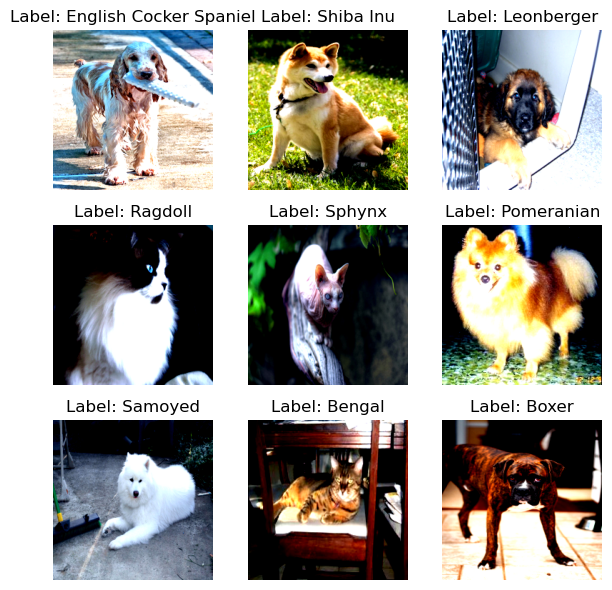

In [45]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

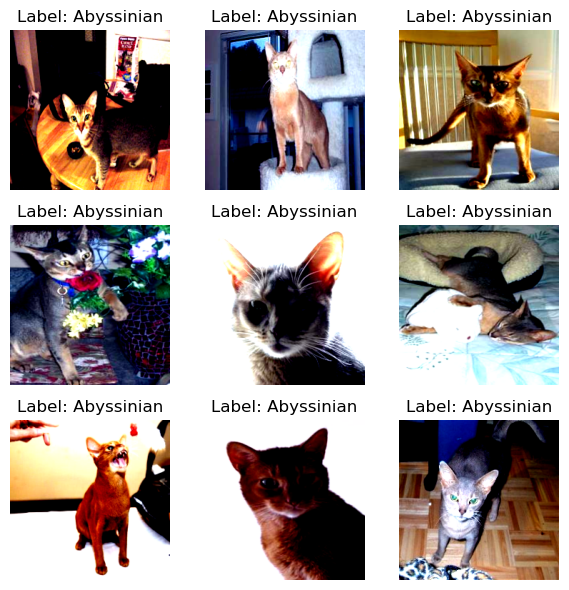

In [46]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

### 모델 준비

In [48]:
resnet_model = resnet34 #resnet50

In [49]:
# resnet_model

#1. 초기설정
current_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

resnet_model_train_losses = []
resnet_model_val_accuracy = []

for epoch in range(EPOCH):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 100 미니배치마다 로그 출력
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")
    
    train_loss = running_loss / len(trainloader)
    resnet_model_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    resnet_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    resnet_model_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

2
Epoch 1: Train Accuracy: 3.99%
Epoch 1: Validation Accuracy: 2.75%
2
Epoch 2: Train Accuracy: 8.86%
Epoch 2: Validation Accuracy: 4.36%
2
Epoch 3: Train Accuracy: 15.16%
Epoch 3: Validation Accuracy: 8.37%
2
Epoch 4: Train Accuracy: 22.12%
Epoch 4: Validation Accuracy: 11.64%
2
Epoch 5: Train Accuracy: 26.01%
Epoch 5: Validation Accuracy: 13.57%
2
Epoch 6: Train Accuracy: 30.30%
Epoch 6: Validation Accuracy: 8.72%
2
Epoch 7: Train Accuracy: 37.80%
Epoch 7: Validation Accuracy: 6.87%
2
Epoch 8: Train Accuracy: 42.80%
Epoch 8: Validation Accuracy: 13.25%
2
Epoch 9: Train Accuracy: 51.25%
Epoch 9: Validation Accuracy: 13.27%
2
Epoch 10: Train Accuracy: 59.13%
Epoch 10: Validation Accuracy: 14.94%
Finished Training
518.2123928070068


In [59]:
plain_model = plain_resnet34 #plain_model50

In [66]:
# plain_model

#1. 초기설정
current_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plain_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(plain_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

plain_model_train_losses = []
plain_model_val_accuracy = []

for epoch in range(EPOCH):
    plain_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = plain_model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 100 미니배치마다 로그 출력
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")
    
    train_loss = running_loss / len(trainloader)
    plain_model_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    plain_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = plain_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    plain_model_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

Epoch 1: Train Accuracy: 5.52%
Epoch 1: Validation Accuracy: 4.58%
Epoch 2: Train Accuracy: 5.38%
Epoch 2: Validation Accuracy: 4.80%
Epoch 3: Train Accuracy: 5.54%
Epoch 3: Validation Accuracy: 5.21%
Epoch 4: Train Accuracy: 5.98%
Epoch 4: Validation Accuracy: 5.72%
Epoch 5: Train Accuracy: 6.82%
Epoch 5: Validation Accuracy: 5.04%
Epoch 6: Train Accuracy: 8.15%
Epoch 6: Validation Accuracy: 6.87%
Epoch 7: Train Accuracy: 9.16%
Epoch 7: Validation Accuracy: 6.98%
Epoch 8: Train Accuracy: 9.32%
Epoch 8: Validation Accuracy: 7.28%
Epoch 9: Train Accuracy: 10.84%
Epoch 9: Validation Accuracy: 8.04%
Epoch 10: Train Accuracy: 11.30%
Epoch 10: Validation Accuracy: 8.15%
Finished Training
503.20420122146606


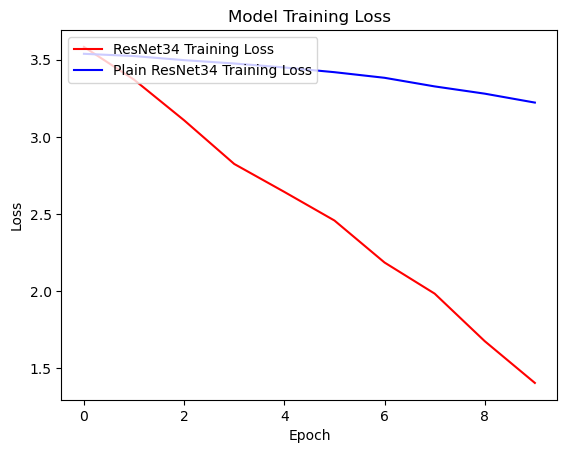

In [72]:
# loss 시각화
plt.plot(resnet_model_train_losses, 'r', label="ResNet34 Training Loss")
plt.plot(plain_model_train_losses, 'b', label="Plain ResNet34 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

결과
-  ResNet34는 Plain 모델보다 epoch가 증가함에따라 loss 감소추세가 더 빠르게 나타난다.

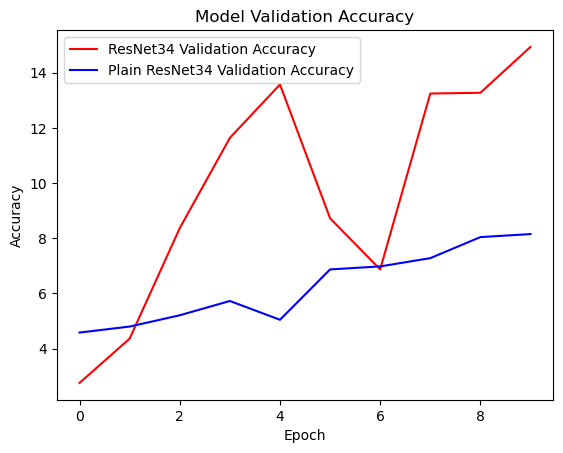

In [74]:
# accuracy 시각화
plt.plot(resnet_model_val_accuracy, 'r', label="ResNet34 Validation Accuracy")
plt.plot(plain_model_val_accuracy, 'b', label="Plain ResNet34 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

결과
-  ResNet34는 Plain 모델보다 epoch가 증가함에따라 Accuracy가 증가추세가 더 빠르게 나타난다.

회고
-  학습에 시간이 너무 많이 걸린다. 코드로 개선할 수 있을까?